In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
import json
import pickle
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by
import matplotlib.patches as mpatches

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [16]:
df['devices'] = [row['source_device'] + '->' + row['target_device'] for i, row in df.iterrows()]
df['device_types'] = [row['source_device_type'] + '->' + row['target_device_type'] for i, row in df.iterrows()]
df['replica'] = ['Replica' if row['source_device'] == row['target_device'] else 'Not replica' for i, row in df.iterrows()]
df['samples_r'] = np.round(df.samples.values / 10) * 10

In [17]:
df_transfer = df.loc[df.type_of_transfer != 'No transfer']

without_transfer = df.loc[df.type_of_transfer == 'No transfer']

df_transfer_synergy = df_transfer.loc[(df_transfer.source_room == 'synergy') & (df_transfer.target_room == 'synergy')]

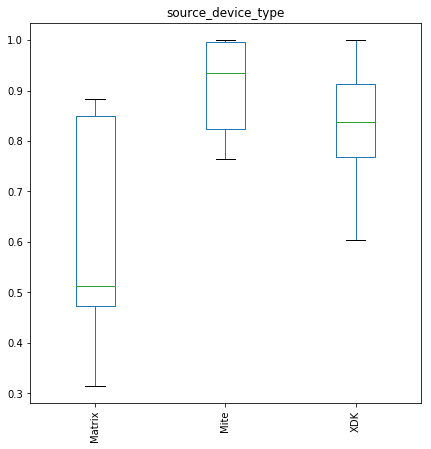

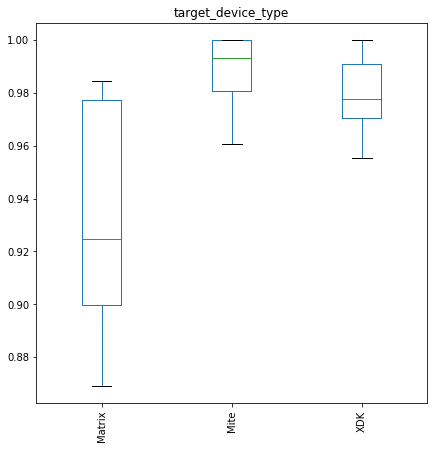

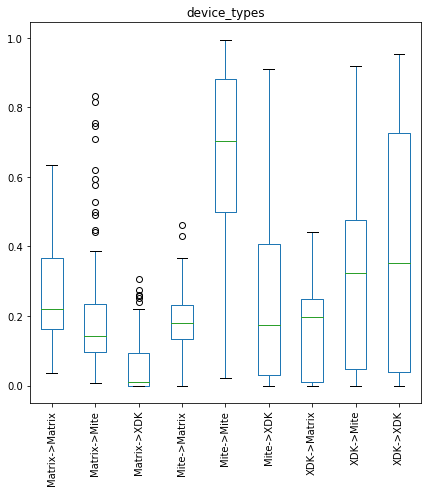

In [4]:
plt.rcParams["figure.figsize"] = (7, 7)

features = 'All'
label = 'Dishes'
value_column = 'f1'
classifier='SVM'

boxplot_by('source_device_type', value_column=value_column, label=label, features=features, classifier=classifier, df_plot=without_transfer)
boxplot_by('target_device_type', value_column='specificity', label=label, features=features, df_plot=without_transfer, classifier=classifier)
boxplot_by('device_types', value_column=value_column, label=label, features='Microphone', df_plot=df_transfer, classifier=classifier)

/home/giotto/.local/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


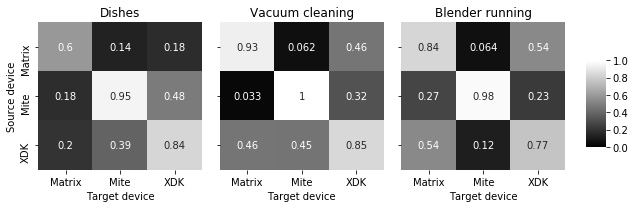

In [25]:
plt.rcParams["figure.figsize"] = (9, 3)

value_column = 'f1'
df_transfer_within_place = df.loc[df.source_placement == df.target_placement]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == df_transfer_within_place.target_room]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type != df_transfer_within_place.target_device_type]
df_transfer_within_place = pd.concat([
    df_transfer_within_place,
    without_transfer
])

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

heatmap_by('target_device_type', 'source_device_type',
           value_column, label='Dishes',
           features='All', classifier='SVM',
           title='Dishes',
           ax=axes[0],
           draw_cbar=True,
           cbar_ax=cbar_ax,
           vmin=0, vmax=1,
           df_plot=df_transfer_within_place
          )
matplotlib.pyplot.sca(axes[0])
plt.ylabel('Source device')
plt.xlabel('Target device')

heatmap_by('target_device_type', 'source_device_type',
           value_column, label='Vacuum cleaning',
           features='All', classifier='SVM',
           title='Vacuum cleaning',
           ax=axes[1],
           draw_cbar=True,
           cbar_ax=cbar_ax,
           vmin=0, vmax=1,
           df_plot=df_transfer_within_place
          )
matplotlib.pyplot.sca(axes[1])
plt.ylabel('')
plt.xlabel('Target device')

heatmap_by('target_device_type', 'source_device_type',
           value_column, label='Blender running',
           features='All', classifier='SVM',
           title='Blender running',
           ax=axes[2],
           draw_cbar=False,
           cbar_ax=None,
           vmin=0, vmax=1,
           df_plot=df_transfer_within_place.loc[df_transfer_within_place.source_room == 'scott']
          )
matplotlib.pyplot.sca(axes[2])
plt.ylabel('')
plt.xlabel('Target device')

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('../plots/heatmap_across_devices.pdf')
plt.show()

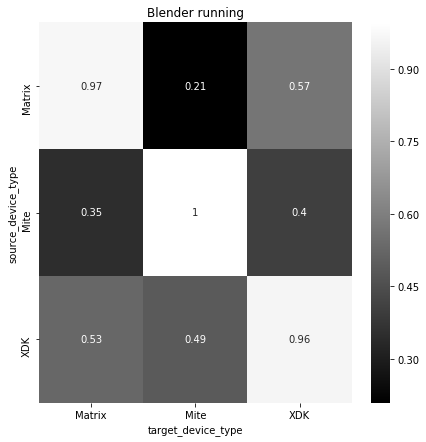

In [23]:
only_best = df
only_best = only_best.sort_values(by='f1', ascending=False)
only_best = only_best.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')

only_best_without_transfer = without_transfer
only_best_without_transfer = only_best_without_transfer.sort_values(by='f1', ascending=False)
only_best_without_transfer = only_best_without_transfer.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')

df_transfer_within_place = only_best.loc[only_best.source_placement == only_best.target_placement]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == df_transfer_within_place.target_room]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type != df_transfer_within_place.target_device_type]
df_transfer_within_place = pd.concat([
    df_transfer_within_place,
    only_best_without_transfer
])

# df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == 'synergy']
heatmap_by('target_device_type', 'source_device_type', 'f1', label='Blender running', features=None, classifier=None, df_plot=df_transfer_within_place)

In [197]:
def to_keys(df, dataset_col='source_dataset', device_col='source_device'):
    return df[dataset_col] + df[device_col] + df['label'] + df['classifier'] + df['features']


def scatter_with_3_dims(df_plot, df_no_transfer, label=None, title='', ax=None, show_y_label=True,
                        from_column='source_placement', to_column='target_placement',
                        dataset=None,
                        use_colors={}, use_markers={}, show_legend=False, classifier='SVM', features='All'):
    plot_df = df_plot
    if label is not None:
        plot_df = df_plot.loc[df_plot['label'] == label]
    if classifier is not None:
        plot_df = plot_df.loc[plot_df.classifier == classifier]
    if features is not None:
        plot_df = plot_df.loc[plot_df.features_name == features]
    if dataset is not None:
        plot_df = plot_df.loc[plot_df.source_dataset == dataset]
        plot_df = plot_df.loc[plot_df.target_dataset == dataset]

    markers_df = pd.DataFrame({
        'from': plot_df[from_column],
        'to': plot_df[to_column],
        'value': plot_df['f1'],
        'position': 1,
        'connect_before': to_keys(plot_df),
        'connect_after': to_keys(plot_df, 'target_dataset', 'target_device')
    })

    no_transfer_keys = to_keys(df_no_transfer)
    no_transfer_keys = no_transfer_keys.drop_duplicates()
    no_transfer_keys = pd.Series(no_transfer_keys.index.values, index=no_transfer_keys)

    used_keys_source = to_keys(plot_df).unique()
    used_keys_target = to_keys(plot_df, 'target_dataset', 'target_device').unique()

    use_colors, use_markers, _ = scatter_plot_by('from', other_column='to',
                        x_value_column='position', y_value_column='value',
                        features=None,
                        classifier=None,
                        label=None,
                        common_limits=False,
                        show_legend=False,
                        xlabel='',
                        ylabel='F1 score' if show_y_label else '',
                        ax=ax,
                        title=title,
                        use_colors=use_colors, use_markers=use_markers,
                        size=0,
                        df_plot=markers_df)

    for key in used_keys_source:
        from_f1 = df_no_transfer['f1'][no_transfer_keys[key]]
        for i, row in markers_df.loc[markers_df.connect_before == key].iterrows():
            to_f1 = row['value']
            plt.plot([0, 1], [from_f1, to_f1],
                     linewidth=3.0,
                     color=use_colors[row['from']], zorder=-100)

    for key in used_keys_target:
        if not key in no_transfer_keys:
            continue
        to_f1 = df_no_transfer['f1'][no_transfer_keys[key]]
        for i, row in markers_df.loc[markers_df.connect_after == key].iterrows():
            from_f1 = row['value']
            plt.plot([1, 2], [from_f1, to_f1],
                     linewidth=3.0,
                     color=use_colors[row['to']], zorder=-100)

    plt.xticks([0, 1, 2], ['Source', 'Transfer', 'Target'])
    
    if show_legend:
        patches = []
        for placement in np.unique(plot_df[from_column].values.tolist() + plot_df[to_column].values.tolist()):
            if placement in use_colors:
                patches.append(mpatches.Patch(color=use_colors[placement], label=placement))
        plt.legend(handles=patches)
    
    return use_colors, use_markers

({'Matrix': array([  1.00000000e+00,   1.22464680e-16,   6.12323400e-17,
           1.00000000e+00]),
  'Mite': array([ 0.50392157,  0.99998103,  0.70492555,  1.        ]),
  'XDK': array([ 0.5,  0. ,  1. ,  1. ])},
 {'Matrix': '^', 'Mite': 'o', 'XDK': 'v'})

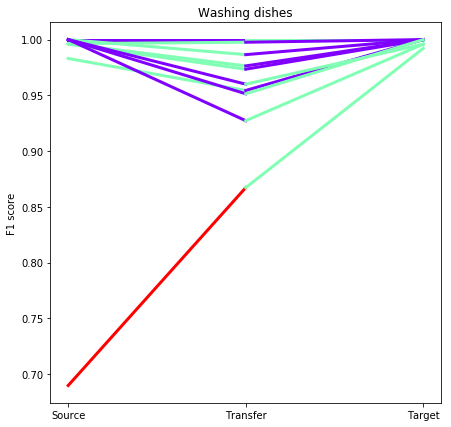

In [104]:
df_transfer_within_place = only_best.loc[only_best.source_placement == only_best.target_placement]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == df_transfer_within_place.target_room]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type != df_transfer_within_place.target_device_type]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.f1 >= 0.8]

scatter_with_3_dims(
    df_plot=df_transfer_within_place,
    df_no_transfer=without_transfer,
    label='Dishes', title='Washing dishes',
    classifier=None, features=None,
    from_column='source_device_type', to_column='target_device_type'
)

# Chopping food is transferring well
# also Blender running

'OK'

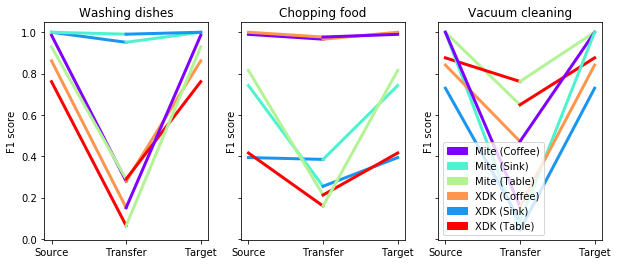

In [200]:
plt.rcParams["figure.figsize"] = (10, 4)

df_transfer_within_place = df.loc[df.source_placement == df.target_placement]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == df_transfer_within_place.target_room]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type != df_transfer_within_place.target_device_type]

df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type.isin(['XDK', 'Mite'])]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.target_device_type.isin(['XDK', 'Mite'])]

df_transfer_within_place['source'] = df['source_device_type'] + ' (' + df['source_placement'] + ')'
df_transfer_within_place['target'] = df['target_device_type'] + ' (' + df['target_placement'] + ')'


fig, axes = plt.subplots(1, 3, sharex=False, sharey=True)

use_colors, use_markers = scatter_with_3_dims(
    df_plot=df_transfer_within_place,
    df_no_transfer=without_transfer,
    dataset='synergy-final-iter1',
    label='Dishes', title='Washing dishes',
    classifier='SVM', features='All',
    ax=axes[0],
    from_column='source', to_column='target'
)

use_colors, use_markers = scatter_with_3_dims(
    df_plot=df_transfer_within_place,
    df_no_transfer=without_transfer,
    dataset='synergy-final-iter1',
    label='Chopping food', title='Chopping food',
    classifier='SVM', features='All',
    use_colors=use_colors, use_markers=use_markers,
    ax=axes[1],
    from_column='source', to_column='target'
)

use_colors, use_markers = scatter_with_3_dims(
    df_plot=df_transfer_within_place,
    df_no_transfer=without_transfer,
    dataset='synergy-final-iter5',
    use_colors=use_colors, use_markers=use_markers,
    label='Vacuum cleaning', title='Vacuum cleaning',
    show_legend=True,
    ax=axes[2],
    classifier='SVM', features='All',
    from_column='source', to_column='target'
)
'OK'

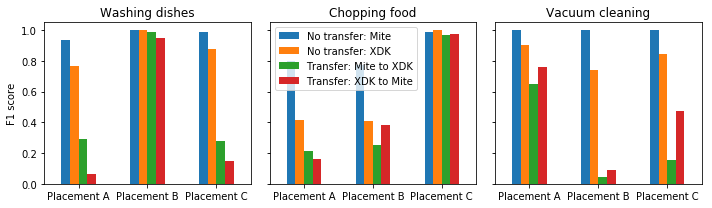

In [38]:
def rename_labels(df_plot, column):
    df_plot = df_plot.copy()
    df_plot[column] = df_plot[column].replace('Coffee', 'Placement C')
    df_plot[column] = df_plot[column].replace('Sink', 'Placement B')
    df_plot[column] = df_plot[column].replace('Table', 'Placement A')
    return df_plot

plt.rcParams["figure.figsize"] = (10, 3)
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)

df_transfer_within_place = df.loc[df.source_placement == df.target_placement]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == df_transfer_within_place.target_room]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type != df_transfer_within_place.target_device_type]

df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type.isin(['XDK', 'Mite'])]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.target_device_type.isin(['XDK', 'Mite'])]

df_transfer_within_place['transfer'] = df['source_device_type'] + ' to ' + df['target_device_type'] + ' (' + df['source_placement'] + ')'

df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.classifier == 'SVM']
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.features_name == 'All']

df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == 'synergy']

df_transfer_within_place = rename_labels(df_transfer_within_place, 'source_placement')
df_transfer_within_place = rename_labels(df_transfer_within_place, 'target_placement')

__df = df_transfer_within_place.loc[df_transfer_within_place.label == 'Dishes']
__df = __df.loc[__df.source_dataset == 'synergy-final-iter1']
__df = __df.loc[__df.target_dataset == 'synergy-final-iter1']
__df_mite = __df.loc[__df.target_device_type == 'Mite']
__df_xdk = __df.loc[__df.target_device_type == 'XDK']
pd.DataFrame({
    'No transfer: Mite': __df_mite.groupby(['source_placement'])['f1_target_wt'].mean(),
    'No transfer: XDK': __df_xdk.groupby(['source_placement'])['f1_target_wt'].mean(),
    'Transfer: XDK to Mite': __df_mite.groupby(['source_placement'])['f1'].mean(),
    'Transfer: Mite to XDK': __df_xdk.groupby(['source_placement'])['f1'].mean()
}).plot.bar(ax=axes[0])
matplotlib.pyplot.sca(axes[0])
plt.title('Washing dishes')
plt.legend().remove()
plt.xlabel('')
plt.ylabel('F1 score')
plt.xticks(rotation=0)

__df = df_transfer_within_place.loc[df_transfer_within_place.label == 'Chopping food']
__df = __df.loc[__df.source_dataset == 'synergy-final-iter1']
__df = __df.loc[__df.target_dataset == 'synergy-final-iter1']
__df_mite = __df.loc[__df.target_device_type == 'Mite']
__df_xdk = __df.loc[__df.target_device_type == 'XDK']
pd.DataFrame({
    'No transfer: Mite': __df_mite.groupby(['source_placement'])['f1_target_wt'].mean(),
    'No transfer: XDK': __df_xdk.groupby(['source_placement'])['f1_target_wt'].mean(),
    'Transfer: XDK to Mite': __df_mite.groupby(['source_placement'])['f1'].mean(),
    'Transfer: Mite to XDK': __df_xdk.groupby(['source_placement'])['f1'].mean()
}).plot.bar(ax=axes[1])
matplotlib.pyplot.sca(axes[1])
plt.title('Chopping food')
plt.legend().remove()
plt.xlabel('')
plt.legend(loc=0)
plt.xticks(rotation=0)

__df = df_transfer_within_place.loc[df_transfer_within_place.label == 'Vacuum cleaning']
__df = __df.loc[__df.source_dataset == 'synergy-final-iter5']
__df = __df.loc[__df.target_dataset == 'synergy-final-iter5']
__df_mite = __df.loc[__df.target_device_type == 'Mite']
__df_xdk = __df.loc[__df.target_device_type == 'XDK']
pd.DataFrame({
    'No transfer: Mite': __df_mite.groupby(['source_placement'])['f1_target_wt'].mean(),
    'No transfer: XDK': __df_xdk.groupby(['source_placement'])['f1_target_wt'].mean(),
    'Transfer: XDK to Mite': __df_mite.groupby(['source_placement'])['f1'].mean(),
    'Transfer: Mite to XDK': __df_xdk.groupby(['source_placement'])['f1'].mean()
}).plot.bar(ax=axes[2])
matplotlib.pyplot.sca(axes[2])
plt.title('Vacuum cleaning')
plt.legend().remove()
plt.xlabel('')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('../plots/across_device_different_placements.pdf')
plt.show()

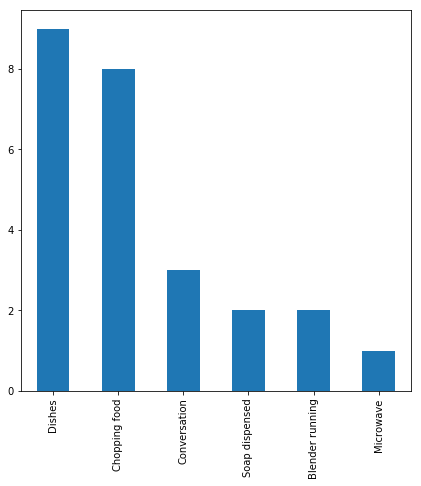

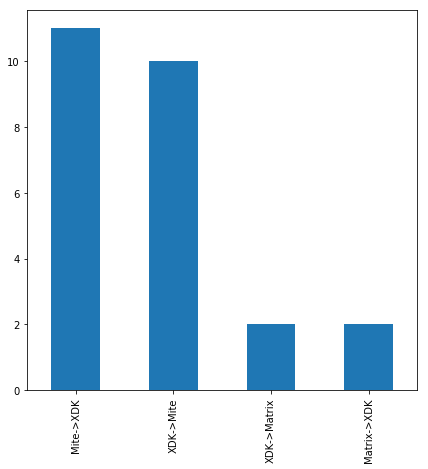

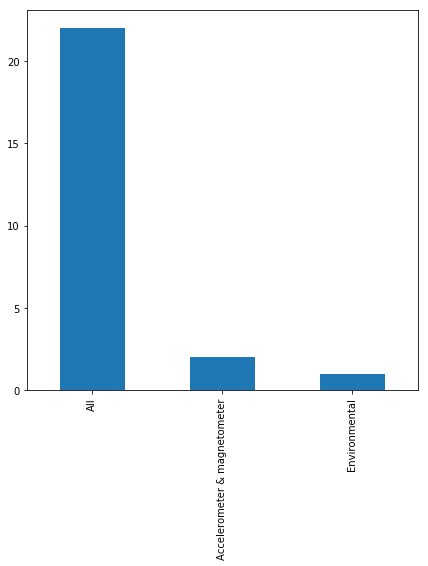

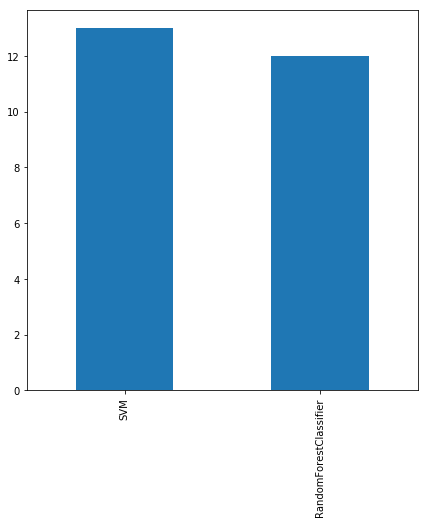

In [112]:
df_transfer_within_place = only_best.loc[only_best.source_placement == only_best.target_placement]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == df_transfer_within_place.target_room]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type != df_transfer_within_place.target_device_type]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.f1 >= 0.9]

df_transfer_within_place.label.value_counts().plot.bar()
plt.show()

df_transfer_within_place.device_types.value_counts().plot.bar()
plt.show()

df_transfer_within_place.features_name.value_counts().plot.bar()
plt.show()

df_transfer_within_place.classifier.value_counts().plot.bar()
plt.show()

In [45]:
df_transfer_within_place = only_best.loc[only_best.source_placement == only_best.target_placement]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type != df_transfer_within_place.target_device_type]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.f1 >= 0.9]

df_transfer_within_place[['source_device_type', 'target_device_type', 'source_placement', 'target_placement', 'label', 'classifier', 'features_name']]

,source_device_type,target_device_type,source_placement,target_placement,label,classifier,features_name
246268,XDK,Mite,Left,Left,Dishes,RandomForestClassifier,All
142218,Mite,XDK,Sink,Sink,Dishes,RandomForestClassifier,All
110554,XDK,Matrix,Sink,Sink,Microwave,SVM,All
60047,Mite,XDK,Coffee,Coffee,Chopping food,RandomForestClassifier,All
270918,Mite,XDK,Left,Left,Dishes,SVM,All
68285,XDK,Mite,Entrance,Entrance,Conversation,RandomForestClassifier,All
144402,XDK,Mite,Coffee,Coffee,Chopping food,RandomForestClassifier,All
142398,Mite,XDK,Sink,Sink,Dishes,RandomForestClassifier,All
119831,Mite,XDK,Coffee,Coffee,Chopping food,SVM,All
47404,Mite,XDK,Sink,Sink,Dishes,SVM,All


In [42]:
only_best = df.loc[df.source_placement == df.target_placement]
only_best = only_best.loc[only_best.source_device_type != only_best.target_device_type]
only_best = only_best.sort_values(by='f1', ascending=False)
only_best.loc[only_best.label == 'Blender running'][['device_types', 'f1']]

,device_types,f1
250691,XDK->Matrix,0.957229
250693,XDK->Matrix,0.954344
250641,XDK->Matrix,0.947917
250741,XDK->Matrix,0.941813
250690,XDK->Matrix,0.940491
250640,XDK->Matrix,0.936937
250740,XDK->Matrix,0.928962
250643,XDK->Matrix,0.927017
249541,Matrix->XDK,0.918991
249540,Matrix->XDK,0.918558


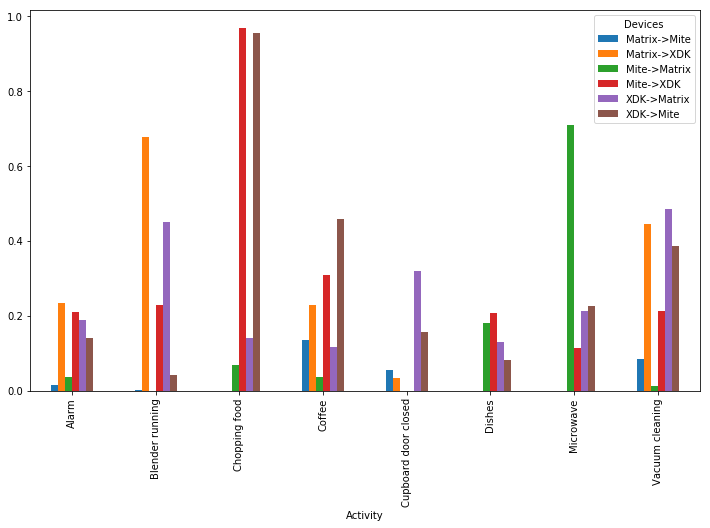

In [160]:
plt.rcParams["figure.figsize"] = (12, 7)

value_column = 'f1'
df_transfer_within_place = df.loc[df.source_placement == df.target_placement]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == df_transfer_within_place.target_room]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type != df_transfer_within_place.target_device_type]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == 'synergy']
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_placement == 'Coffee']
# df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.target_device_type == 'Mite']

df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.label.isin([
    'Alarm', 'Blender running', 'Vacuum cleaning', 'Coffee',
    'Chopping food', 'Dishes', 'Microwave',  'Cupboard door closed'
])]

df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.classifier == 'SVM']
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.features_name == 'All']

df_transfer_within_place = df_transfer_within_place.groupby(['label', 'device_types'])[value_column].mean()
df_transfer_within_place = df_transfer_within_place.reset_index()
df_transfer_within_place = df_transfer_within_place.rename(columns={'label': 'Activity', 'device_types': 'Devices'})
df_transfer_within_place.pivot(index='Activity', columns='Devices', values=value_column).plot.bar()

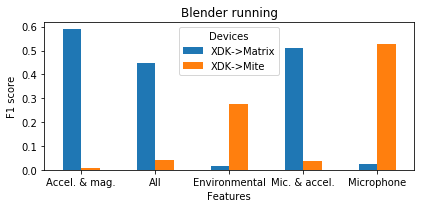

In [48]:
plt.rcParams["figure.figsize"] = (6, 3)

def rename_features(df):
    df = df.copy()
    df['features_name'] = df['features_name'].map({
        'All': 'All',
        'Microphone': 'Microphone',
        'Microphone & accelerometer': 'Mic. & accel.',
        'Environmental': 'Environmental',
        'EMI & motion': 'EMI & motion',
        'Accelerometer & magnetometer': 'Accel. & mag.',
    })
    return df



value_column = 'f1'
df_transfer_within_place = df.loc[df.type_of_transfer == 'Different device in same place']
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_room == 'synergy']
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_placement == 'Coffee']
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_device_type.isin(['XDK'])]
df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.target_device_type.isin(['Mite', 'Matrix'])]
# df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.source_dataset == df_transfer_within_place.target_dataset]
# df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.target_dataset == 'synergy-final-iter5']

df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.label.isin([
    'Blender running'
])]

df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.classifier == 'SVM']
# df_transfer_within_place = df_transfer_within_place.loc[df_transfer_within_place.features_name == 'All']

df_transfer_within_place = df_transfer_within_place.groupby(['features_name', 'device_types'])[value_column].mean()
df_transfer_within_place = df_transfer_within_place.reset_index()

df_transfer_within_place = rename_features(df_transfer_within_place)

df_transfer_within_place = df_transfer_within_place.rename(columns={'features_name': 'Features', 'device_types': 'Devices'})

df_transfer_within_place.pivot(index='Features', columns='Devices', values=value_column).plot.bar()
plt.title('Blender running')
plt.ylabel('F1 score')
    
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../plots/channel_performance_across_devices.pdf')
plt.show()

In [39]:
df_transfer_within_place

,source_dataset,target_dataset,source_device_id,target_device_id,source_device,target_device,source_device_name,target_device_name,source_device_type,target_device_type,...,accuracy_target_wt,recall_target_wt,specificity_target_wt,precision_target_wt,f1_target_wt,devices,device_types,replica,samples_r,transfer
129021,synergy-final-iter1,synergy-final-iter1,128.237.246.127,xdk_3,Mite 1,XDK 3,Mite 1 Coffee,XDK 3 Coffee,Mite,XDK,...,1.000000,1.000000,1.000000,1.000000,1.000000,Mite 1->XDK 3,Mite->XDK,Not replica,360.0,Mite to XDK (Coffee)
129026,synergy-final-iter1,synergy-final-iter1,128.237.246.127,xdk_3,Mite 1,XDK 3,Mite 1 Coffee,XDK 3 Coffee,Mite,XDK,...,0.988927,0.955834,0.994230,0.964080,0.959928,Mite 1->XDK 3,Mite->XDK,Not replica,380.0,Mite to XDK (Coffee)
129031,synergy-final-iter1,synergy-final-iter1,128.237.246.127,xdk_3,Mite 1,XDK 3,Mite 1 Coffee,XDK 3 Coffee,Mite,XDK,...,0.964108,0.851670,0.984278,0.906604,0.877782,Mite 1->XDK 3,Mite->XDK,Not replica,420.0,Mite to XDK (Coffee)
129036,synergy-final-iter1,synergy-final-iter1,128.237.246.127,xdk_3,Mite 1,XDK 3,Mite 1 Coffee,XDK 3 Coffee,Mite,XDK,...,0.803742,0.376322,0.875155,0.337765,0.355430,Mite 1->XDK 3,Mite->XDK,Not replica,380.0,Mite to XDK (Coffee)
129041,synergy-final-iter1,synergy-final-iter1,128.237.246.127,xdk_3,Mite 1,XDK 3,Mite 1 Coffee,XDK 3 Coffee,Mite,XDK,...,0.861016,0.483392,0.919690,0.483589,0.483473,Mite 1->XDK 3,Mite->XDK,Not replica,330.0,Mite to XDK (Coffee)
129046,synergy-final-iter1,synergy-final-iter1,128.237.246.127,xdk_3,Mite 1,XDK 3,Mite 1 Coffee,XDK 3 Coffee,Mite,XDK,...,0.994654,0.133333,0.998850,0.500000,0.206349,Mite 1->XDK 3,Mite->XDK,Not replica,20.0,Mite to XDK (Coffee)
129687,synergy-final-iter1,synergy-final-iter1,128.237.248.186,xdk_1,Mite 2,XDK 1,Mite 2 Table,XDK 1 Table,Mite,XDK,...,0.836377,0.439422,0.898165,0.400995,0.417114,Mite 2->XDK 1,Mite->XDK,Not replica,360.0,Mite to XDK (Table)
129692,synergy-final-iter1,synergy-final-iter1,128.237.248.186,xdk_1,Mite 2,XDK 1,Mite 2 Table,XDK 1 Table,Mite,XDK,...,0.985160,0.935221,0.992583,0.948720,0.941825,Mite 2->XDK 1,Mite->XDK,Not replica,380.0,Mite to XDK (Table)
129697,synergy-final-iter1,synergy-final-iter1,128.237.248.186,xdk_1,Mite 2,XDK 1,Mite 2 Table,XDK 1 Table,Mite,XDK,...,0.926941,0.773668,0.955464,0.762676,0.766697,Mite 2->XDK 1,Mite->XDK,Not replica,420.0,Mite to XDK (Table)
129702,synergy-final-iter1,synergy-final-iter1,128.237.248.186,xdk_1,Mite 2,XDK 1,Mite 2 Table,XDK 1 Table,Mite,XDK,...,0.834094,0.433924,0.905029,0.448110,0.440775,Mite 2->XDK 1,Mite->XDK,Not replica,380.0,Mite to XDK (Table)
